# Part 1: Conjugate gradient descent

For his first part of the lab we are going to explore quadratic functions and learn some methods to minimize them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from IPython.display import clear_output, display

#### **1. Which of the following matrices are positive, semipositive or negative definite?**

Positive definite: eigenvalues > 0 (<x,Ax> > 0)

Negative definite: eigenvalues < 0

Positive semidefinite: eigenvalues >= 0

Negative semidefinite: eginvalues <=0

In [2]:
# Define the matrixes
D1 = np.matrix([[-2, 0], [0, 4]])
D2 = np.matrix([[0, 0], [0, 2]])
D3 = np.matrix([[0.5, 0], [0, 1.5]])
A1 = np.matrix([[1, -3], [-3, 1]])
A2 = np.matrix([[1, -1], [-1, 1]])
A3 = np.matrix([[1, -.5], [-.5, 1]])

In [3]:
# TODO: Build up the code to demonstrate which matrices are
#       positive definite and reasoning what you are implementing
for key, matrix in {"D1":D1, "D2":D2, "D3":D3, "A1":A1, "A2":A2, "A3":A3}.items():
    eig_values = np.linalg.eig(matrix)[0]
    
    if np.all(eig_values > 0):
        kind= 'positive definite'
    else:
        kind= 'not positive definite'
        
    print('Matrix {} is {} (eigen_values = {})'.format(key, kind, eig_values))

Matrix D1 is not positive definite (eigen_values = [-2.  4.])
Matrix D2 is not positive definite (eigen_values = [0. 2.])
Matrix D3 is positive definite (eigen_values = [0.5 1.5])
Matrix A1 is not positive definite (eigen_values = [ 4. -2.])
Matrix A2 is not positive definite (eigen_values = [2. 0.])
Matrix A3 is positive definite (eigen_values = [1.5 0.5])


#### **2. The Python script quad_fun_main plots contours of the quadratic functions g<sub>i</sub>(x) =〈x, D<sub>i</sub>x〉and f<sub>i</sub>(x)  =〈x, A<sub>i</sub>x〉for  the  above  matrices.** 

- How  many  minima  does  each function have?  

G1 and F1 haven't any minima, they contain a saddle point, which is a maximum in one direction and a minima in other.
G2 and F2 have infite minimums.
G3 and F3 have one global minimum.

- Which is the relation between the g<sub>i</sub> and f<sub>i</sub>? 

Notice that both in the surface and 3D plot we find the same plot but rotated. This because although the matrixes are different, the eigenvalues are the same.

In [4]:
def quad_fun_main(matrixes: dict):
    # Define the x1 and x2 axis and mesh to draw the level lines
    x1 = np.arange(start = -10, stop = 10.1, step = 0.1)
    x2 = np.arange(start = -10, stop = 10.1, step = 0.1)
    X, Y = np.meshgrid(x1, x2)

    # Calculate Z
    x = np.matrix([X.T.flatten(), Y.T.flatten()])
    results = {}
    for key, matrix in matrixes.items():
        print("Procesing {}".format(key))
        aux = np.matmul(matrix, x)
        result = np.zeros((x1.shape[0], x2.shape[0]))
        for j in range(result.shape[0]):
            for i in range(result.shape[1]):
                result[i, j] = (x[:, result.shape[0] * j + i].T * aux[:, result.shape[0] * j + i])
        if key.startswith("D"):
            matrix_name = "G{}".format(key[-1])
        else:
            matrix_name = "F{}".format(key[-1])
        print("\tSaving as {}".format(matrix_name))
        results[matrix_name] = result

    # Plot the contours
    fig, axs = plt.subplots(nrows = int(len(results) / 3), 
                        ncols = 3, 
                        figsize = (14,8))
    for row in range(axs.shape[0]):
        for column in range(axs.shape[1]):
            matrix_name = list(results.keys())[axs.shape[0] * row + row + column]
            Z = results.get(matrix_name)
            axs[row, column].contour(X, Y, Z, 
                                     corner_mask = False, levels = 150, 
                                     linewidths=(1,), cmap = cm.coolwarm)
            axs[row, column].set_title(matrix_name)    
        
    # Plot the surfaces
    fig = plt.figure(figsize=(16, 10))
    for row in range(axs.shape[0]):
        for column in range(axs.shape[1]):
            ax = fig.add_subplot(axs.shape[0], axs.shape[1], axs.shape[0] * row + row + column + 1, projection='3d')
            matrix_name = list(results.keys())[axs.shape[0] * row + row + column]
            Z = results.get(matrix_name)
            ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
            ax.set_title(matrix_name)    

Procesing D1
	Saving as G1
Procesing D2
	Saving as G2
Procesing D3
	Saving as G3
Procesing A1
	Saving as F1
Procesing A2
	Saving as F2
Procesing A3
	Saving as F3


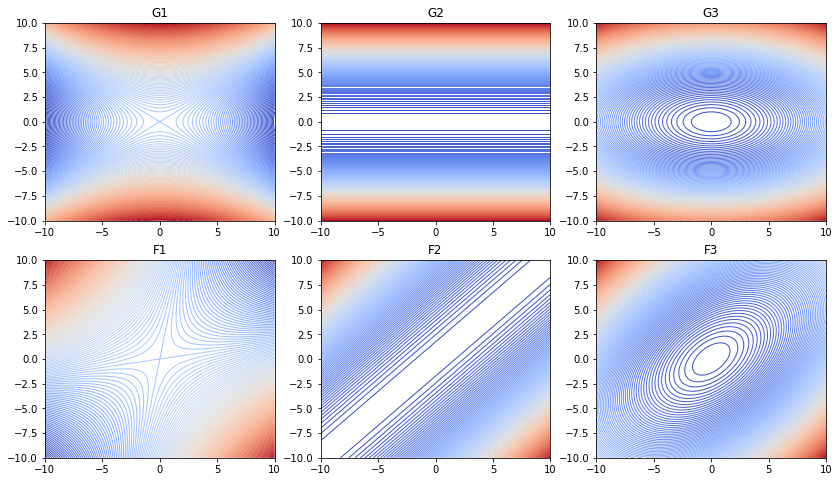

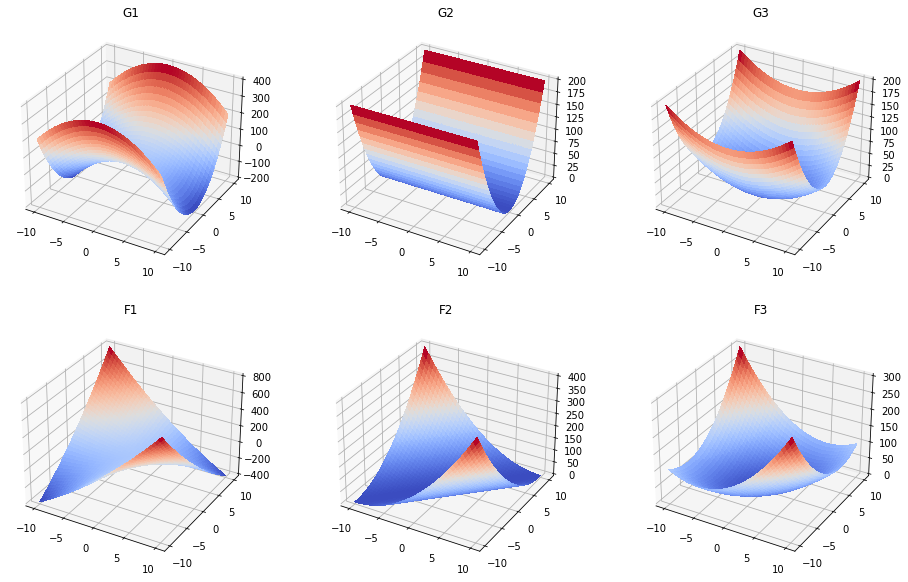

In [5]:
# Define the matrixes dictionary
matrixes = {"D1": D1, "D2": D2, "D3": D3, "A1": A1, "A2": A2, "A3": A3}

# Run the quad_fun_main
quad_fun_main(matrixes)

#### **3. Complete the code of the Python function grad_descent().Follow the comments in the code.**

Now we will use the gradient descent method (also seen in the previous lab) which minimizes the function in the most descent direction of the function, but this time using a dynamic step length.

In [6]:
def multiply_ax(x):
    return A * x

In [7]:
def gradient_descent(callback,
                     b: np.matrix,
                     callback_params: dict,
                     initial_condition: np.matrix,
                     max_iters: int,
                     tolerance: float,
                     fig = None,
                     ax = None):
    """
    Implementation of the gradient descent algorithm (a
    gradient descent scheme with optimal adaptive step size) for the minimization
    of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a Python function implementing the product with matrix A.
    :param b: vector b, can be in matrix form (MxN)
    :param callback_params: a dictionary with the callback function params
    :param x0: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """
    Ax = callback(initial_condition, **callback_params)
    r = Ax-b                        # TODO: compute residual (the gradient)
    nr = np.multiply(r,r).sum()                     # TODO: inner product of gradient
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # TODO: Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        value = 0.5*np.multiply(r,current_value).sum() -0.5*np.multiply(b,current_value).sum()
        fs.append(value)

        # 1. line search in r - compute time step alpha
        Ar = callback(r, **callback_params)
        alpha = nr / (np.multiply(r, Ar).sum())

        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value - alpha *r

        # TODO: compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax-b                        # TODO: compute residual (the gradient)
        nr = np.multiply(r,r).sum()                      # TODO: inner product of gradient
    
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "k")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-k")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0 or it == 1:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
    
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

#### **4. Complete the code of the Python function conj_grad. Follow the comments in the code**

In this part we will implement the conjugate gradient method, which works building a basis of conjugate methods with respect to A and each iteration Xk+1 is the given by the same formula as before, but the descent direction is defined by di, and defining the error  conguta to di we obtain that the step length is the same as before.  

To compute this basis of descent directions dk is defined as a linear combination of the current gradient and the previous step direction. In the formula you can see a B, which is defined to obtain the directions as a conjugate basis of Rn.

In [8]:
def conjugate_gradient(callback,
                       b: np.matrix,
                       callback_params: dict,
                       initial_condition: np.matrix,
                       tolerance: float,
                       max_iters: int,
                       fig = None,
                       ax = None):
    """
    implementation of the conjugate gradient algorithm for the minimization of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a Python function implementing the product with matrix A. 
    :param callback_params: dictionary containing the params for the callback functions
    :param b: vector b, can be in matrix form (MxN)
    :param initial_conditions: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """

    Ax = callback(initial_condition, **callback_params)
    r = Ax - b                        # TODO: compute residual (the gradient)
    nr = np.multiply(r,r).sum()                     # TODO: inner product of gradient
    d = -r.copy()                     # TODO: first descent direction is the negative grad.
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        if it % 10 == 0:
            print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        fs.append(0.5 * np.multiply(r, current_value).sum() - 0.5 * np.multiply(b, current_value).sum())

        # 1. TODO: line search in d - compute time step alpha
        Ad = callback(d, **callback_params)
        alpha = np.multiply(d,r).sum()/np.multiply(d,Ad).sum()
        
        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value - alpha *d

        # compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax - b                       # TODO: compute residual (the gradient)
        nr_old = nr                       # inner product of the old residual
        nr = np.multiply(r,r).sum()                      # TODO: squared norm of gradient

        # A-orthogonalization of r (Gram-Schmidt)
        # new search direction d is a linear combination of r and previous d
        # chosen so that it is A-orthogonal with the previous search directions
        beta_2 = nr/ nr_old
        d = -r.copy() + beta_2*d
        
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "r")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-r")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
                
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

#### **5. Run the functions conj_grad_test_i with i = 1, 2, 3.These script computes the minima of quadratic functions in R2 and R100. Complete the code if needed and answerthe questions in the code.**

In [9]:
A = None

**conj_grad_test_1**

In [10]:
def conj_grad_test_1():
    global A
    # We start by visualizing a problem in IR^2, and comparing the gradient descent with the conjugate gradient

    # --------------------------------------------------------------------------------------
    # create grid to plot contours of quadratic function -----------------------------------
    # --------------------------------------------------------------------------------------
    x1 = np.arange(start = -10, stop = 10.1, step = 0.1)
    x2 = np.arange(start = -10, stop = 10.1, step = 0.1)
    X, Y = np.meshgrid(x1, x2)

    # matrix containing all grid points as columns
    x = np.matrix([X.T.flatten(), Y.T.flatten()])

    # --------------------------------------------------------------------------------------
    # start with a trivial example: a quadratic function based on the identity matrix ------
    # --------------------------------------------------------------------------------------
    A = np.matrix([[1, 0], [0, 1]])
    b = np.matrix([[4], [3]])

    # evaluate function for all points in x
    Ax = A * x
    bx = b.T * x

    result = np.zeros((x1.shape[0], x2.shape[0]))
    for j in range(result.shape[0]):
        for i in range(result.shape[1]):
            result[i, j] = 0.5 * x[:, result.shape[0] * j + i].T * Ax[:, result.shape[0] * j + i] - bx[:, result.shape[0] * j + i]

    # Plot the contour of f
    fig = plt.figure()
    plt.contour(X, Y, result, 
                corner_mask = False, levels = 150, 
                linewidths=(1,), cmap = cm.coolwarm)
    plt.title('Level lines of f(x) = 1/2 x^T I x - bx')

    # run gradient descent 
    tolerance = 1e-5
    max_iters = 1000
    x1 = gradient_descent(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.matrix([[1.5], [9.5]]),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters, 
                          fig = fig,
                          ax = plt.gca())
    
    #run conjugate gradient
    x2=  conjugate_gradient(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.matrix([[-10], [-7.5]]),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters, 
                          fig = fig,
                          ax = plt.gca())
    
    return x1,x2

- How many iterations does the gradient descent need to converge? Why?

 1, because A is the identity matrix, therefore the graident will be (x0-b), the step size=1(cause Av=v) and looking at the definition of x1 you get that x1=b, which is the exact point we are looking for.
    
    
- How many iterations would the conjugate gradient need to converge? Why?

 At most 2, but in this case since we are dealing with the identity matrix it always will take 1 step. As before, if you do the computations by hands it will converge to b un 1 step.




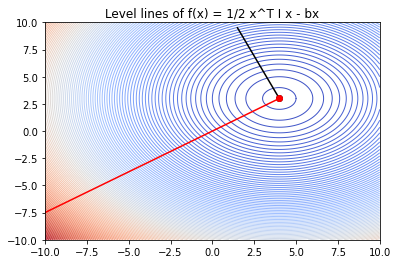

[1 of 1000]	-> |grad f(x)| = 0.0


((matrix([[4.],
          [3.]]),
  matrix([[11.75]])),
 (matrix([[4.],
          [3.]]),
  matrix([[140.625]])))

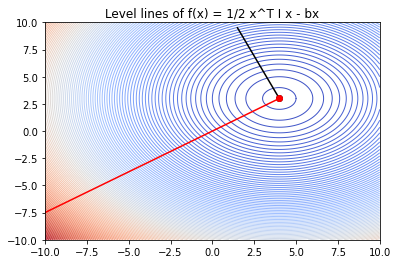

In [11]:
conj_grad_test_1() #Gradient descent black, conjugate descent red

**conj_grad_test_2**

In [12]:
def conj_grad_test_2():
    global A
    # We start by visualizing a problem in IR^2, and comparing the gradient descent with the conjugate gradient

    # --------------------------------------------------------------------------------------
    # create grid to plot contours of quadratic function -----------------------------------
    # --------------------------------------------------------------------------------------
    x1 = np.arange(start = -10, stop = 10.1, step = 0.1)
    x2 = np.arange(start = -10, stop = 10.1, step = 0.1)
    X, Y = np.meshgrid(x1, x2)

    # matrix containing all grid points as columns
    x = np.matrix([X.T.flatten(), Y.T.flatten()])

    # --------------------------------------------------------------------------------------
    # a more general quadratic function ----------------------------------------------------
    # --------------------------------------------------------------------------------------
    A = np.matrix([[1, .9], [.9, 1]])
    b = np.matrix([[1], [2]])

    # evaluate function for all points in x
    Ax = A * x
    bx = b.T * x

    result = np.zeros((x1.shape[0], x2.shape[0]))
    for j in range(result.shape[0]):
        for i in range(result.shape[1]):
            result[i, j] = 0.5 * x[:, result.shape[0] * j + i].T * Ax[:, result.shape[0] * j + i] - bx[:, result.shape[0] * j + i]

    # Plot the contour of f
    fig = plt.figure()
    ax = plt.gca()
    plt.contour(X, Y, result, 
                corner_mask = False, levels = 150, 
                linewidths=(1,), cmap = cm.coolwarm)
    plt.title('Level lines of f(x) = 1/2 x^T I x - bx')

    # run gradient descent 
    tolerance = 0.00001
    max_iters = 1000
    x1 = gradient_descent(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.matrix([[5], [-5]]),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters, 
                          fig = fig,
                          ax = ax)

    # run gradient descent 
    tolerance = 0.00001
    max_iters = 100
    x2 = conjugate_gradient(callback = multiply_ax,
                            b = b, 
                            callback_params = {},  
                            initial_condition = np.matrix([[5], [-5]]),  # TRY several starting points
                            tolerance = tolerance,
                            max_iters = max_iters, 
                            fig = fig,
                            ax = ax)


- How many iterations does the gradient descent need to converge?

 101
    
    
- Does the performance of the gradient descent depend on the position of the initial condition? 

 Yes, for example an initial point close to the minimum generally will converge faster (you can check it) than a far point or a point at the same distance but with smaller gradients in it's neighbourhood.


- Are there any initial conditions for which the gradient descent converges in one iteration?

 If you have a very high tolerance or you are lucky that you started very close to the minimum it can converge in one iteration. Also if A is an identity matrix always will converge in one iteration, but in general there is no garantee that it will take 1 iteration


- Which is the angle between consecutive descent directions for the gradient descent? Why?
90 degrees, because minimizing the function in the gradient in a direction v leads to a point tangent to the level curve in this direction v, and since we have seen in theory, the gradient at this point (which also is the next step direction) will be orthogonal to the level curve, and the degree will be 90.   
    
    
- How many iterations would the conjugate gradient need to converge? Why?

At most n iterations. This method is defined in a way that you only have to take a direction once, and it os a bit intuitive that if the directions keep orthogonal there are at most n steps (n is the dimension of the matrix A). Also in the theory slides there is a formal proof which would take much more time to explain.

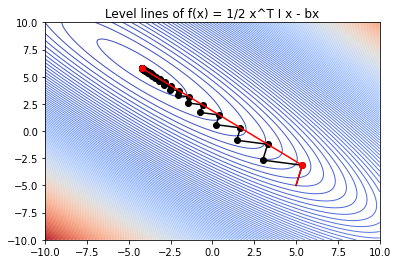

[2 of 100]	-> |grad f(x)| = 7.888609052210118e-31


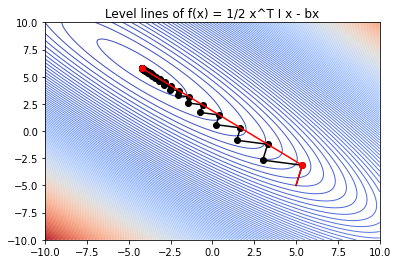

In [13]:
conj_grad_test_2()

In [14]:
def conj_grad_test_3():
    global A
    # Now we compare the gradient descent and the conjugate gradient for a problem in IR^100. 

    # Define the problem matrix. Is it symmetric? Is it positive definite?
    A = np.matrix(np.ones(shape = (100, 100)) + np.diag(np.arange(0, 100)))
    b = np.matrix(np.ones(shape = (100, 1)))

    # run gradient descent 
    tolerance = 10 ** -5
    max_iters = 10 ** 6
    x1, fs_1 = gradient_descent(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.zeros_like(b),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters)

    # run gradient descent 
    tolerance = 10 ** -5
    max_iters = 100
    x2, fs_2 = conjugate_gradient(callback = multiply_ax,
                            b = b, 
                            callback_params = {},  
                            initial_condition = np.zeros_like(b),  # TRY several starting points
                            tolerance = tolerance,
                            max_iters = max_iters)

    m = -0.5 * b.T * np.linalg.lstsq(A, b)[0]
    m = m[0,0]

    fig, ax = plt.subplots(figsize = (14, 8))
    ax.semilogy(fs_1 - m)
    ax.semilogy(fs_2 - m, 'r') 
    ax.legend(['gradient descent', 'conjugate gradient'])
    ax.set_title('logarithmic plot of f(x_i) - f^*')

       

- Which one converges faster?

 Cojugate descent: at most 100 iterations while the gradient descent can take thousands.
    
    
- Which is the order of convergence of the gradient descent?

 Linear (order 1)


- Why is the logarithmic plot of the error for the gradient descent linear?

 Because the convergence is linear which means that the error of each iteration decrease in a linear way (ek= r^k * e0)


- Which is the maximum number of iterations needed for the conjugate gradient?

 100, as before the number of dimensions (size of matrix A)


[1 of 1000000]	-> |grad f(x)| = 100.0
[2 of 1000000]	-> |grad f(x)| = 3.7281462176038316
[3 of 1000000]	-> |grad f(x)| = 2.281773074269803
[4 of 1000000]	-> |grad f(x)| = 0.8793913050693424
[5 of 1000000]	-> |grad f(x)| = 0.9567206536855981
[6 of 1000000]	-> |grad f(x)| = 0.5080692459887942
[7 of 1000000]	-> |grad f(x)| = 0.6174591613824196
[8 of 1000000]	-> |grad f(x)| = 0.3477295782300809
[9 of 1000000]	-> |grad f(x)| = 0.44690729354242137
[10 of 1000000]	-> |grad f(x)| = 0.2607313022562135
[11 of 1000000]	-> |grad f(x)| = 0.34717011523953306
[12 of 1000000]	-> |grad f(x)| = 0.20731827789428556
[13 of 1000000]	-> |grad f(x)| = 0.2827853803058607
[14 of 1000000]	-> |grad f(x)| = 0.1716585992182581
[15 of 1000000]	-> |grad f(x)| = 0.23824607879222945
[16 of 1000000]	-> |grad f(x)| = 0.14637990894394812
[17 of 1000000]	-> |grad f(x)| = 0.20582991956637584
[18 of 1000000]	-> |grad f(x)| = 0.1276381412579008
[19 of 1000000]	-> |grad f(x)| = 0.18130448404439117
[20 of 1000000]	-> |grad f(x

[855 of 1000000]	-> |grad f(x)| = 0.001739923528928053
[856 of 1000000]	-> |grad f(x)| = 0.0011401985594808894
[857 of 1000000]	-> |grad f(x)| = 0.001725718176563586
[858 of 1000000]	-> |grad f(x)| = 0.0011308895743252932
[859 of 1000000]	-> |grad f(x)| = 0.0017116288017304687
[860 of 1000000]	-> |grad f(x)| = 0.0011216565910238858
[861 of 1000000]	-> |grad f(x)| = 0.0016976544575476715
[862 of 1000000]	-> |grad f(x)| = 0.0011124989890710112
[863 of 1000000]	-> |grad f(x)| = 0.0016837942048642373
[864 of 1000000]	-> |grad f(x)| = 0.0011034161530262597
[865 of 1000000]	-> |grad f(x)| = 0.001670047112196696
[866 of 1000000]	-> |grad f(x)| = 0.0010944074724746017
[867 of 1000000]	-> |grad f(x)| = 0.0016564122556658512
[868 of 1000000]	-> |grad f(x)| = 0.0010854723419839079
[869 of 1000000]	-> |grad f(x)| = 0.001642888718936939
[870 of 1000000]	-> |grad f(x)| = 0.0010766101610656849
[871 of 1000000]	-> |grad f(x)| = 0.0016294755931554727
[872 of 1000000]	-> |grad f(x)| = 0.0010678203341336

[1676 of 1000000]	-> |grad f(x)| = 3.9560570776114795e-05
[1677 of 1000000]	-> |grad f(x)| = 5.987588345596099e-05
[1678 of 1000000]	-> |grad f(x)| = 3.923758425516716e-05
[1679 of 1000000]	-> |grad f(x)| = 5.9387035522196044e-05
[1680 of 1000000]	-> |grad f(x)| = 3.891723471069627e-05
[1681 of 1000000]	-> |grad f(x)| = 5.890217871616429e-05
[1682 of 1000000]	-> |grad f(x)| = 3.8599500613414086e-05
[1683 of 1000000]	-> |grad f(x)| = 5.8421280452929084e-05
[1684 of 1000000]	-> |grad f(x)| = 3.828436060993002e-05
[1685 of 1000000]	-> |grad f(x)| = 5.7944308413581464e-05
[1686 of 1000000]	-> |grad f(x)| = 3.7971793521106814e-05
[1687 of 1000000]	-> |grad f(x)| = 5.747123054300017e-05
[1688 of 1000000]	-> |grad f(x)| = 3.7661778340805006e-05
[1689 of 1000000]	-> |grad f(x)| = 5.7002015047848303e-05
[1690 of 1000000]	-> |grad f(x)| = 3.735429423428823e-05
[1691 of 1000000]	-> |grad f(x)| = 5.653663039428776e-05
[1692 of 1000000]	-> |grad f(x)| = 3.704932053700916e-05
[1693 of 1000000]	-> |g

[2541 of 1000000]	-> |grad f(x)| = 1.7346332504679285e-06
[2542 of 1000000]	-> |grad f(x)| = 1.1367317588944152e-06
[2543 of 1000000]	-> |grad f(x)| = 1.720471089819275e-06
[2544 of 1000000]	-> |grad f(x)| = 1.1274510779320616e-06
[2545 of 1000000]	-> |grad f(x)| = 1.7064245540699905e-06
[2546 of 1000000]	-> |grad f(x)| = 1.1182461677394704e-06
[2547 of 1000000]	-> |grad f(x)| = 1.6924926992181595e-06
[2548 of 1000000]	-> |grad f(x)| = 1.109116409695528e-06
[2549 of 1000000]	-> |grad f(x)| = 1.6786745889594455e-06
[2550 of 1000000]	-> |grad f(x)| = 1.1000611902336876e-06
[2551 of 1000000]	-> |grad f(x)| = 1.6649692946618622e-06
[2552 of 1000000]	-> |grad f(x)| = 1.0910799007890141e-06
[2553 of 1000000]	-> |grad f(x)| = 1.6513758952402487e-06
[2554 of 1000000]	-> |grad f(x)| = 1.0821719377797444e-06
[2555 of 1000000]	-> |grad f(x)| = 1.637893477147697e-06
[2556 of 1000000]	-> |grad f(x)| = 1.0733367025312585e-06
[2557 of 1000000]	-> |grad f(x)| = 1.624521134296982e-06
[2558 of 1000000]	

[3940 of 1000000]	-> |grad f(x)| = 3.6899197606406785e-09
[3941 of 1000000]	-> |grad f(x)| = 5.584783059743182e-09
[3942 of 1000000]	-> |grad f(x)| = 3.659793947895109e-09
[3943 of 1000000]	-> |grad f(x)| = 5.539186911957712e-09
[3944 of 1000000]	-> |grad f(x)| = 3.629914093007331e-09
[3945 of 1000000]	-> |grad f(x)| = 5.493963026689832e-09
[3946 of 1000000]	-> |grad f(x)| = 3.600278187866291e-09
[3947 of 1000000]	-> |grad f(x)| = 5.449108365342475e-09
[3948 of 1000000]	-> |grad f(x)| = 3.5708842407391395e-09
[3949 of 1000000]	-> |grad f(x)| = 5.404619913053247e-09
[3950 of 1000000]	-> |grad f(x)| = 3.541730276110899e-09
[3951 of 1000000]	-> |grad f(x)| = 5.36049468069954e-09
[3952 of 1000000]	-> |grad f(x)| = 3.512814334872388e-09
[3953 of 1000000]	-> |grad f(x)| = 5.3167297022825664e-09
[3954 of 1000000]	-> |grad f(x)| = 3.4841344737171283e-09
[3955 of 1000000]	-> |grad f(x)| = 5.273322036658339e-09
[3956 of 1000000]	-> |grad f(x)| = 3.4556887648832793e-09
[3957 of 1000000]	-> |grad 

<ipython-input-14-79dedfaf53e3>:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m = -0.5 * b.T * np.linalg.lstsq(A, b)[0]


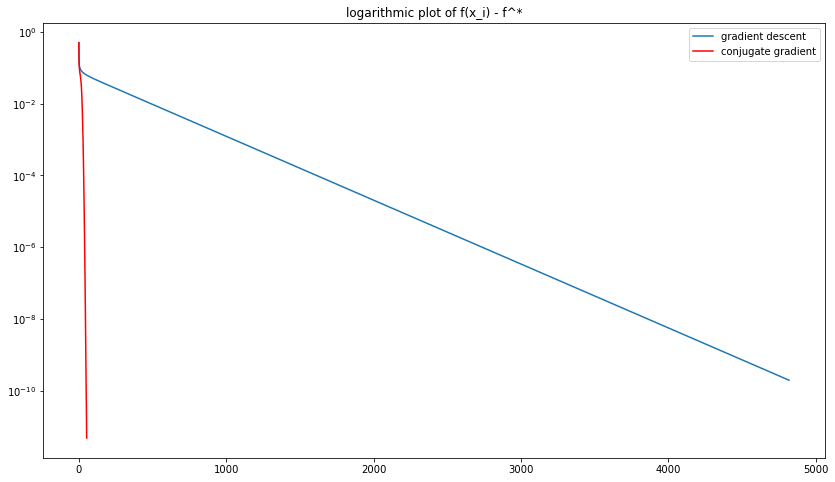

In [15]:
conj_grad_test_3()